In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from pathlib import Path
from tqdm import tqdm
import re
from sklearn import metrics

In [2]:
PROJECT_ROOT_PATH = Path('.').resolve().parent.parent
ANJUKE_DATA_PATH = PROJECT_ROOT_PATH/'data/anjuke'
RAW_DATA_PATH = PROJECT_ROOT_PATH/'data/raw_data'

In [3]:
SUB_DATA_PATHS = [x for x in ANJUKE_DATA_PATH.iterdir() if x.is_dir() and str(x.name).startswith('anjuke')]

In [4]:
SUB_DATA_PATHS

[PosixPath('/nfs/volume-242-1/weiguoao_i/House-Property-QA/data/anjuke/anjuke_qa_data_bj'),
 PosixPath('/nfs/volume-242-1/weiguoao_i/House-Property-QA/data/anjuke/anjuke_qa_data_cq'),
 PosixPath('/nfs/volume-242-1/weiguoao_i/House-Property-QA/data/anjuke/anjuke_qa_data_sh'),
 PosixPath('/nfs/volume-242-1/weiguoao_i/House-Property-QA/data/anjuke/anjuke_qa_data_sz')]

In [5]:
cities = [x.name[-2:] for x in SUB_DATA_PATHS]
cities

['bj', 'cq', 'sh', 'sz']

In [6]:
import json

In [7]:
city2samples = {}
for data_path in tqdm(SUB_DATA_PATHS):
    city = data_path.name[-2:]
    samples = []
    with open(data_path/'part_0.json', 'r') as f:
        lines = [x.strip() for x in f.readlines()]
    samples.extend(lines)
    with open(data_path/'part_1.json', 'r') as f:
        lines = [x.strip() for x in f.readlines()]
    samples.extend(lines)
    
    samples = [json.loads(s) for s in samples]
    city2samples[city] = samples

100%|██████████| 4/4 [00:00<00:00, 29.03it/s]


In [8]:
city2samples['bj'][0]

{'question': '外地人能买二手房吗',
 'answers': ['可以，需要有北京社保或北京工作居住证，公司名义全款吧购买',
  '外地户口在京购房有一定的条件限制，需要满足最近连续60个月在京社保或者最近连续60个月在京完税证明就可以在京购房，有北京工作居住证的也可以在京购房。也可以以公司名义在京全款购房。',
  '可以的，需要有北京五年社保和纳税，有北京工作证也是可以购房的，也可以以公司名义全款购买',
  '可以的，需要有北京五年社保和纳税，有北京工作证也是可以购房的，也可以以公司名义全款购买',
  '可以购房，需要连续不间断缴纳5年社保或者纳税，有北京工作居住证也可以够房，也可以以公司名义全款购买',
  '外地人，需要在北京有连续5年的社保或者纳税哦，或者有北京工作居住证，其次可以 以公司名义全款购买，但一般不建议这种操作，税费比较高',
  '可以的，我老家是辽源的 在这边买房了，希望可以帮助你',
  '连续缴存社保或纳税60个月，中间没有断缴就可以',
  '连续缴存社保或纳税 60个月',
  '您好，首先您得连续交满5年的社保或纳税证明，注意是连续的如果中间断档太久肯定是不行的。外地户籍以家庭为单位只能在京购买一套房',
  '连续缴纳北京社保60个月',
  '您好，外地人若在北京买房，需要有连续5年社保，或五年连续纳税，并在购买房屋是不可断缴。请做参考，祝早日找到心仪的房子。',
  '您好，外地户口需要在买房前社保或者纳税连续60个月就能买房，以家庭为单位1套。还有需要了解的请微聊或者致电。',
  '连续五年社保或纳税证明就可以',
  '只要钱到位 肯定没问题',
  '外地户口需要连续缴纳五年社保就可以有购房资质了',
  '您好，外地户口社保或交税连续够60个月就可以',
  '外地户口 社保或交税连续够60个月就可以 买一套',
  '外地户口 社保或交税连续够60个月就可以 买一套',
  '连续5年社保可获得购房资格。'],
 'url': 'https://beijing.anjuke.com/ask/all/?from=wd_rmwd'}

In [9]:
qid = 0
df_anjuke = []
for city, samples in tqdm(city2samples.items()):
    formatted_samples = []

    for s in samples:
        q1 = s['question']
        q2s = s['answers']

        for i, q2 in enumerate(q2s):
            formatted_samples.append([qid, q1, i, q2, 1, city])
        qid += 1
    
    df_anjuke.extend(formatted_samples)

100%|██████████| 4/4 [00:00<00:00, 149.71it/s]


In [10]:
df_anjuke = pd.DataFrame(data=df_anjuke, columns=['id', 'q1', 'id_sub', 'q2', 'label', 'city'])

In [11]:
df_anjuke

,id,q1,id_sub,q2,label,city
0,0,外地人能买二手房吗,0,可以，需要有北京社保或北京工作居住证，公司名义全款吧购买,1,bj
1,0,外地人能买二手房吗,1,外地户口在京购房有一定的条件限制，需要满足最近连续60个月在京社保或者最近连续60个月在京完...,1,bj
2,0,外地人能买二手房吗,2,可以的，需要有北京五年社保和纳税，有北京工作证也是可以购房的，也可以以公司名义全款购买,1,bj
3,0,外地人能买二手房吗,3,可以的，需要有北京五年社保和纳税，有北京工作证也是可以购房的，也可以以公司名义全款购买,1,bj
4,0,外地人能买二手房吗,4,可以购房，需要连续不间断缴纳5年社保或者纳税，有北京工作居住证也可以够房，也可以以公司名义全款购买,1,bj
...,...,...,...,...,...,...
37824,5316,【翡翠海岸】 这个小区的房子是单本证还是双本证?,3,您好，高兴为您解答翡翠海岸这个小区只有B栋20楼以下包含20楼是双本证，其他所有的面积都是单...,1,sz
37825,5317,【星河世纪大厦】 小区地段如何？升值空间大吗？,0,小区中心区地段，升值空间不错,1,sz
37826,5318,【鹊山新二村】 两房一厅，1980元这个价钱真实嘛？,0,这个价格相对来说，是不真实的,1,sz
37827,5319,pC耐力板多少钱一厘或是多少钱一公斤,0,耐力板的计价一般来说有两种方式： A，按照表面积的平方价，是指1mm厚底的板材1平方米的价格...,1,sz


In [12]:
df_anjuke.to_csv(ANJUKE_DATA_PATH/'anjuke_pos.tsv',sep='\t',index=False, header=None)

In [13]:
df_train = pd.read_csv(RAW_DATA_PATH/'train/train.tsv', sep='\t', header=None, names=['id', 'q1', 'id_sub', 'q2', 'label'])

In [14]:
df_train

,id,q1,id_sub,q2,label
0,0,采荷一小是分校吧,0,杭州市采荷第一小学钱江苑校区，杭州市钱江新城实验学校。,1
1,0,采荷一小是分校吧,1,是的,0
2,0,采荷一小是分校吧,2,这是5楼,0
3,1,毛坯吗？,0,因为公积金贷款贷的少,0
4,1,毛坯吗？,1,是呢,0
...,...,...,...,...,...
21580,5998,您好，我正在看尚林家园的房子,1,有啊,0
21581,5998,您好，我正在看尚林家园的房子,2,我带你看看,0
21582,5999,今天可以安排看房子吗？,0,我约下房东，稍后回你,1
21583,5999,今天可以安排看房子吗？,1,可以看，你几点有时间过来呢？,1


In [15]:
def get_overlap_count(a, b):
    a = list(a)
    b = list(b)
    overlap_char = set(a).intersection(b)
    return len(overlap_char)

In [16]:
print(df_anjuke['q2'].iloc[0], df_anjuke['q2'].iloc[1])
print(get_overlap_count(df_anjuke['q2'].iloc[0], df_anjuke['q2'].iloc[1]))

可以，需要有北京社保或北京工作居住证，公司名义全款吧购买 外地户口在京购房有一定的条件限制，需要满足最近连续60个月在京社保或者最近连续60个月在京完税证明就可以在京购房，有北京工作居住证的也可以在京购房。也可以以公司名义在京全款购房。
23


In [17]:
df_neg = []
for id in tqdm(df_anjuke['id'].unique()):
    df_sub = df_anjuke[df_anjuke['id'] == id]
    num_pos_samples = df_sub.shape[0]
    city = df_sub['city'].unique()[0]
    q1 = df_sub['q1'].unique()[0]

    # 随机从其他城市的答案中采样负样本，并且保证重叠字符数较低，
    # 尽量避免选到和正样本太相似的负样本
    neg_cities = list(city2samples.keys())
    neg_cities.remove(city)
    neg_city = np.random.choice(neg_cities)
    
    while True:
        neg_samples = np.random.choice(city2samples[neg_city], size=num_pos_samples*3, replace=False)
        neg_samples = [x['answers'][0] for x in neg_samples]
        # 随机从比赛数据集的回答中采样负样本
        # neg_samples = np.random.choice(df_train['q2'], size=num_pos_samples*3, replace=False)
        
        flags = []
        for pos in df_sub['q2']:
            for neg in neg_samples:
                flags.append(get_overlap_count(pos, neg))
        flags = np.asarray(flags)
        if flags.mean() < 10:    # 比赛数据长度较小，阈值设小为2，从安居客抽取负样本可以设为10
            break

    id_sub_start = max(df_sub['id_sub']) + 1
    for i, q2 in enumerate(neg_samples):
        df_neg.append([id, q1, id_sub_start + i, q2, 0, neg_city])
        # df_neg.append([id, q1, id_sub_start + i, q2, 0, 'org'])

100%|██████████| 5321/5321 [00:31<00:00, 166.44it/s]


In [18]:
df_neg = pd.DataFrame(data=df_neg, columns=['id', 'q1', 'id_sub', 'q2', 'label', 'city'])

In [19]:
df_neg.head()

,id,q1,id_sub,q2,label,city
0,0,外地人能买二手房吗,20,外墙保温首选 a级发泡水泥板，我们就生产这个,0,sh
1,0,外地人能买二手房吗,21,对的都是民用的水电煤气，第一阶梯电：平0.617元，谷：0.307元，水：3.45元，煤气:...,0,sh
2,0,外地人能买二手房吗,22,大部分都是满五年的,0,sh
3,0,外地人能买二手房吗,23,比对了很多后，现在的东莞钱锋特殊胶粘制品，导热系数稳定，粘性较一般国内品牌稳定，没发生过位移...,0,sh
4,0,外地人能买二手房吗,24,你好，可以用玻璃或者金属丝做帘底现在有专用的金属漆可以对暖气时行色彩粉刷，这样可以根据墙体色...,0,sh


In [20]:
df_anjuke_full = pd.concat([df_anjuke, df_neg]).sort_values(by=['id', 'id_sub'], ignore_index=True)

In [21]:
df_anjuke_full

,id,q1,id_sub,q2,label,city
0,0,外地人能买二手房吗,0,可以，需要有北京社保或北京工作居住证，公司名义全款吧购买,1,bj
1,0,外地人能买二手房吗,1,外地户口在京购房有一定的条件限制，需要满足最近连续60个月在京社保或者最近连续60个月在京完...,1,bj
2,0,外地人能买二手房吗,2,可以的，需要有北京五年社保和纳税，有北京工作证也是可以购房的，也可以以公司名义全款购买,1,bj
3,0,外地人能买二手房吗,3,可以的，需要有北京五年社保和纳税，有北京工作证也是可以购房的，也可以以公司名义全款购买,1,bj
4,0,外地人能买二手房吗,4,可以购房，需要连续不间断缴纳5年社保或者纳税，有北京工作居住证也可以够房，也可以以公司名义全款购买,1,bj
...,...,...,...,...,...,...
151311,5319,pC耐力板多少钱一厘或是多少钱一公斤,3,因为疫情接房时间稍微延迟，暂时定在22年9月份,0,cq
151312,5320,问问各位哪个牌子床上四件套面料软一点,0,富安娜牌子的床上四件套面料软一点。这种牌子的以梭织纯棉，纱织密度越高，品质越好舒适保暖，经久...,1,sz
151313,5320,问问各位哪个牌子床上四件套面料软一点,1,私立学校，树人小学和宏帆八中,0,cq
151314,5320,问问各位哪个牌子床上四件套面料软一点,2,你好老师 总价在70万左右,0,cq


In [22]:
df_anjuke_full.to_csv(ANJUKE_DATA_PATH/'anjuke_full.tsv',sep='\t',index=False, header=None)

In [45]:
df_anjuke_full[df_anjuke_full['id'] == 0]

,id,q1,id_sub,q2,label,city
0,0,外地人能买二手房吗,0,可以，需要有北京社保或北京工作居住证，公司名义全款吧购买,1,bj
1,0,外地人能买二手房吗,1,外地户口在京购房有一定的条件限制，需要满足最近连续60个月在京社保或者最近连续60个月在京完...,1,bj
2,0,外地人能买二手房吗,2,可以的，需要有北京五年社保和纳税，有北京工作证也是可以购房的，也可以以公司名义全款购买,1,bj
3,0,外地人能买二手房吗,3,可以的，需要有北京五年社保和纳税，有北京工作证也是可以购房的，也可以以公司名义全款购买,1,bj
4,0,外地人能买二手房吗,4,可以购房，需要连续不间断缴纳5年社保或者纳税，有北京工作居住证也可以够房，也可以以公司名义全款购买,1,bj
...,...,...,...,...,...,...
75,0,外地人能买二手房吗,75,鸿翔花园是大花园社区，70年产权，民水民电,0,org
76,0,外地人能买二手房吗,76,差额个稅,0,org
77,0,外地人能买二手房吗,77,你这边是考虑套三嘛 只要装修了的嘛,0,org
78,0,外地人能买二手房吗,78,怎么称呼您,0,org


In [46]:
print(f'训练集问题数量：{len(df_anjuke_full["q1"].unique())}，答案数量：{len(df_anjuke_full)}')

训练集问题数量：4999，答案数量：151316


In [51]:
print(len(df_anjuke_full[df_anjuke_full['label'] == 0]))
print(len(df_anjuke_full[df_anjuke_full['label'] == 1]))

113487
37829


In [47]:
q_length = df_anjuke_full["q1"].drop_duplicates().apply(func=lambda x: len(x)).sort_values()
a_length = df_anjuke_full["q2"].apply(func=lambda x: len(str(x))).sort_values()

问题和回答的长度分布：


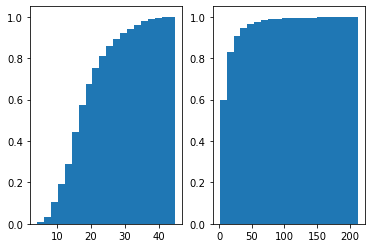

In [48]:
print('问题和回答的长度分布：')
plt.subplot(121)
plt.hist(q_length[:-50], density=True, cumulative=True, bins=20)
plt.subplot(122)
plt.hist(a_length.sort_values()[:-500], density=True, cumulative=True, bins=20)
plt.show()

In [49]:
# 随机抽取2500个问题
df_anjuke_sub = df_anjuke_full[df_anjuke_full['id'].isin(np.random.choice(df_anjuke_full["id"].unique(), size=1500, replace=False))]
df_anjuke_sub.shape

(42564, 6)

In [50]:
df_anjuke_sub.to_csv(ANJUKE_DATA_PATH/'anjuke_sub.tsv',sep='\t',index=False, header=None)